# Forecasting in Aquaponics

Libraries and setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import sys

os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# np.set_printoptions(threshold=sys.maxsize)

mpl.rcParams['figure.figsize'] = (14, 8)
mpl.rcParams['axes.grid'] = True

np.random.seed(10)

## Data adquisition

### Data adquisition

In [2]:
def read_file(textfile):
    df = pd.read_csv(textfile, compression='zip', sep="\t")
    df.drop(df.columns[0], axis=1, inplace=True)
    print('Dataset ready')
    return df

textfile = "dataset_aquaponics_03012021_05222021.txt.zip"
df = read_file(textfile)

Dataset ready


Organize data in columns

In [3]:

df_grouped = pd.pivot_table(df, index = 'DateTime', columns = 'Label', values = 'Value')
df_grouped.index = pd.to_datetime(df_grouped.index)

start_date = pd.to_datetime('2021-04-01 00:00:00')
end_date = pd.to_datetime('2021-04-17 23:59:59')

df_grouped = df_grouped.loc[start_date:end_date]
print(df_grouped.head())

Label                      1         2    3       4       5          6    \
DateTime                                                                   
2021-04-01 00:00:12  20.880000  51.34556  0.0  6.6498  6.6667  44.003500   
2021-04-01 00:00:38  20.822498  51.09667  0.0  6.6498  6.6667  44.007060   
2021-04-01 00:01:04  20.853998  51.17500  0.0  6.6514  6.6681  43.999874   
2021-04-01 00:05:57  20.928003  50.80000  0.0  6.6584  6.6718  43.621853   
2021-04-01 00:06:23  21.000000  50.68667  0.0  6.6596  6.6731  42.650578   

Label                      7       8       9       10   ...       107  \
DateTime                                                ...             
2021-04-01 00:00:12  49.062016  99.262  95.587  11.690  ...  50.53125   
2021-04-01 00:00:38  49.063637  99.262  95.587  11.690  ...  50.53125   
2021-04-01 00:01:04  49.068360  99.255  95.599  11.687  ...  52.50001   
2021-04-01 00:05:57  49.068610  99.289  95.774  11.615  ...  52.50001   
2021-04-01 00:06:23  49.07313

Data visualization

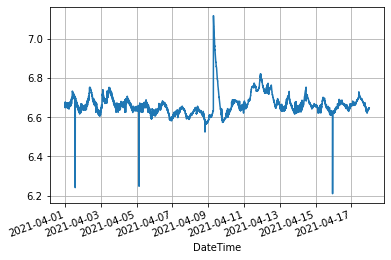

In [4]:
sample_sensor = 4

df_grouped[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.show()

## Data Pre-processing

### Selecting target 

Target variables:

* 4     = pH sump B
* 5     = pH sump A
* 8     = % oxygen B
* 9     = % oxygen A
* 93*   = Weight cell 1
* 99*   = Nitrate B 
* 100*  = Ammonia B
* 103*  = Nitrate A 
* 104*  = Ammonia A
* sensors are not online yet*

In [5]:
label_target = {
4: 'pH sump B',}
# 5: 'pH sump A',}
# 8: '% oxygen B',}
# 9: '% oxygen A'}

### Select features - Human knowledge

In [6]:
drop_signal = [3, 12, 13, 14, 15, 22, 23, 24, 25, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 56, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 93, 94, 95, 97, 98, 99, 100, 101, 104, 105, 106, 111, 112, 113, 114]
df_grouped  = df_grouped.drop(columns = drop_signal)
print(df_grouped.head())

Label                      1         2       4       5          6    \
DateTime                                                              
2021-04-01 00:00:12  20.880000  51.34556  6.6498  6.6667  44.003500   
2021-04-01 00:00:38  20.822498  51.09667  6.6498  6.6667  44.007060   
2021-04-01 00:01:04  20.853998  51.17500  6.6514  6.6681  43.999874   
2021-04-01 00:05:57  20.928003  50.80000  6.6584  6.6718  43.621853   
2021-04-01 00:06:23  21.000000  50.68667  6.6596  6.6731  42.650578   

Label                      7       8       9       10      11   ...    91   \
DateTime                                                        ...          
2021-04-01 00:00:12  49.062016  99.262  95.587  11.690  13.552  ...  406.0   
2021-04-01 00:00:38  49.063637  99.262  95.587  11.690  13.552  ...  406.0   
2021-04-01 00:01:04  49.068360  99.255  95.599  11.687  13.528  ...  406.0   
2021-04-01 00:05:57  49.068610  99.289  95.774  11.615  13.512  ...  406.0   
2021-04-01 00:06:23  49.073135  99

### Denoising dataframe - FFT filter

Check sampling frecuency

In [7]:
sampling_time = df_grouped.index.to_series().diff().median()
print(sampling_time)

0 days 00:00:26


Design sample filter

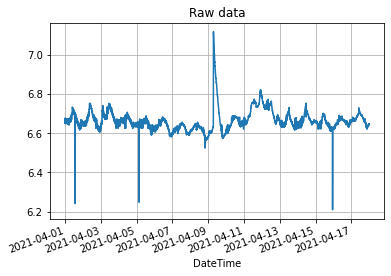

In [8]:
def f_filtering(df, cutt_fc):
    
    new_df = df.copy() 
    index = df.index
    
    dt = 25 # seconds
    n_samples = new_df.shape[0]
    
    # Fast Fourier transform
    f_hat = np.fft.fft(df.to_numpy())
    f_mag_2 = np.real(f_hat * np.conj(f_hat)) / n_samples
    fc_df = (1 / (dt * n_samples)) * np.arange(n_samples)
    
    # Cutting frecuency
    ind_filter = f_mag_2 > cutt_fc
    
    # Filter signal
    f_hat_clean = f_hat * ind_filter
    filter_signal = np.fft.ifft(f_hat_clean)
    
    
    filter_signal = np.real(filter_signal)
    
    return filter_signal

df_grouped[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.title('Raw data')
plt.show()

# Cutting frecuency
cutt_fc = {
1: 5,   
2: 150,     
4: 0.001,   
5: 0.005,   
6: 25,   
7: 25,   
8: 1,   
9: 1,  
10: 0.1,  
11: 0.1,  
16: 0.1,  
17: 0.1,
18: 500,  
19: 5,  
20: 20,  
21: 20, 
102: 10, 
103: 50}

df_clean = df_grouped.copy()

# for sensor in cutt_fc:
#     df_clean[sensor] = f_filtering(df_grouped[sensor], cutt_fc[sensor])
    
# print(df_clean.shape)

# df_clean[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
# plt.xticks(rotation=20)
# plt.title('Filtered data')
# plt.show()

### Feature selection via correlation analysis

Describe  dataset

In [9]:
print(df_clean.describe().transpose())

         count         mean           std          min          25%  \
Label                                                                 
1      28636.0    19.391888      1.699759    14.888001    18.188002   
2      28636.0    43.098705     11.559430    15.972223    33.881387   
4      28636.0     6.664216      0.051004     6.210000     6.636400   
5      28636.0     6.675076      0.034890     6.116000     6.666700   
6      28636.0    46.009057      2.698169    33.928627    43.997658   
7      28636.0    47.539641      3.026140    30.119194    45.693269   
8      28636.0   101.171154      2.667098    94.335000    99.433000   
9      28636.0    96.048075      4.579891    88.220000    92.955000   
10     28636.0    13.012148      0.706207    11.117000    12.511000   
11     28636.0    13.447863      0.572697    12.027000    13.062000   
16     28636.0    10.730241      0.314434     9.751400    10.513000   
17     28636.0    10.101525      0.501803     9.000000     9.753000   
18    

## Split dataset: train, validation and test

In [10]:
total_data = len(df_clean)

train_perc, val_perc, test_perc = 0.7, 0.2, 0.1

train_df    = df_clean[0:int(total_data*train_perc)]
val_df      = df_clean[int(total_data*train_perc):int(total_data*(train_perc + val_perc))]
test_df     = df_clean[int(total_data*(train_perc + val_perc)):total_data]

## Data normalization

Min-max normalization

In [11]:
def f_normalize_minmax(no_norm_df, df):
    norm_df = (no_norm_df - df.min()) / (df.max() - df.min())
    return norm_df

norm_train_df   = f_normalize_minmax(train_df, df_clean)
norm_val_df     = f_normalize_minmax(val_df, df_clean)
norm_test_df    = f_normalize_minmax(test_df, df_clean)

Show tails with box plot

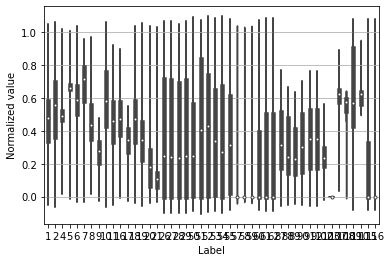

In [12]:
melt_train_df = norm_train_df.melt(var_name = 'Label', value_name = 'Normalized value')
plt.figure()
ax = sns.violinplot(x = 'Label', y = 'Normalized value', data = melt_train_df)
plt.show()

Plot normalized data

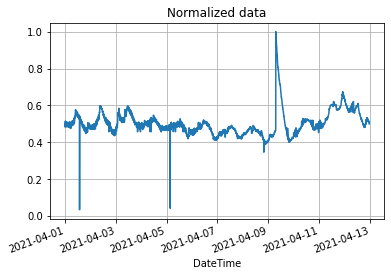

In [13]:
norm_train_df[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.title('Normalized data')
plt.show()

## Create input and target dataframe - Window generation

In [14]:
n_hour_data = 65 # 65 entries ~ 1 hour - There is a variable sampling frecuency
n_hours_in  = 2
n_hours_out = 1

input_width     = n_hour_data * n_hours_in 
label_width     = n_hour_data * n_hours_out 
offset_width    = 1 # 1 as default

def f_window_gen(df, label_target, input_width, label_width, offset_width):

    time_range = df.index
    data = []
    target = []

    data_time = []
    target_time = []

    for i in range(len(time_range) - (input_width + offset_width + label_width)):
        range_data = df.loc[time_range[i]:time_range[input_width + i]].values
        data.append(range_data)
        data_time.append(time_range[i:input_width + i])

        range_target = df[label_target].loc[time_range[input_width + offset_width + i: input_width + offset_width + label_width + i]].values
        target.append(range_target.flatten('F'))
        target_time.append(time_range[input_width + offset_width + i: input_width + offset_width + label_width + i])

    data = np.array(data)
    target = np.array(target)

    return data, target, data_time, target_time

train_data, train_target, train_data_time, train_target_time = f_window_gen(norm_train_df, label_target, input_width, label_width, offset_width)
val_data, val_target, val_data_time, val_target_time = f_window_gen(norm_val_df, label_target, input_width, label_width, offset_width)
test_data, test_target, test_data_time, test_target_time = f_window_gen(norm_test_df, label_target, input_width, label_width, offset_width)

Plotting - Normalized values

In [15]:
def plot_results(label_target, label_time, label, results, label_width):
    n_label = np.int(len(label_target))

    sensor_tag = list(label_target.values())
    
    fig, ax = plt.subplots(n_label, sharex = 'all')
    
    for i in range(n_label):

        label_plot = label[((i) * label_width): ((i + 1)* label_width)]
        ax.plot(label_time, label_plot, color = 'blue', label = 'Real')
        
        results_plot = results[((i) * label_width): ((i + 1)* label_width)]
        ax.plot(label_time, results_plot, color = 'orange', label = 'Prediction')

        ax.set_ylabel(sensor_tag[i])

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc = 'center right')
    plt.xticks(rotation=20)
    plt.xlabel('Day - Time')
    plt.ylim([0., 1.])
    plt.show()

    pass

### Plotting - History

In [16]:
def plot_history(history):

    acc = history.history['mean_absolute_error']
    val_acc = history.history['val_mean_absolute_error']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    fig, ax = plt.subplots(2, sharex = 'all')

    # Plot training and validation accuracy per epoch
    ax[0].plot(epochs, acc, label = 'Training')
    ax[0].plot(epochs, val_acc, label = 'Validation')
    ax[0].title.set_text('Training and validation MAE')

    # Plot training and validation loss per epoch
    ax[1].plot(epochs, loss, label = 'Training')
    ax[1].plot(epochs, val_loss, label = 'Validation')
    ax[1].title.set_text('Training and validation loss')

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc = 'center right')
    plt.xticks(rotation=20)
    plt.xlabel('epochs')
    plt.show()

## Architecture and Deployment

Callbacks

In [17]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.9

Training method

In [18]:
def compile_and_fit(model, train_data, train_target, val_data, val_target, 
                    test_data, test_target, max_epochs, batch_size, test_entry, label_width):

    # Add callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                  patience = 3)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 0)
    callbacks = [early_stop, lr_scheduler]

    # Model compile
    model.compile(loss      = tf.losses.MeanSquaredError(),
                  optimizer = tf.keras.optimizers.Nadam(),
                  metrics   = [tf.metrics.MeanAbsoluteError()])

    # Model fit
    history = model.fit(train_data,
                        train_target,
                        batch_size = batch_size,
                        epochs  = max_epochs,
                        verbose = 1,
                        shuffle = False, 
                        validation_data = (val_data, val_target))

    model.summary()
    
    # Model evaluate
    loss_eval, metric_eval = model.evaluate(test_data, test_target, verbose = 0)
    print("Evaluation loss: {} ---- Evaluation metric:{}".format(loss_eval, metric_eval))

    # Test model
    test_data = np.reshape(test_data[test_entry], (1, test_data[0].shape[0], test_data[0].shape[1]))
    test_prediction = model.predict(test_data)
    
    test_prediction = np.squeeze(test_prediction)
    
    # Plot results
    plot_results(label_target, test_target_time[test_entry], test_target[test_entry], test_prediction, label_width)

    plot_history(history)

    return history, test_prediction

test_entry = np.random.randint(0, 100)

# Models

## Linear model

In [33]:
def f_linear_model(label_target, label_width):
    model = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
        
            tf.keras.layers.Dense(units = 800, kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
        
            tf.keras.layers.Dense(units = 400, kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
        
            tf.keras.layers.Dense(units = 200, kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
        
            tf.keras.layers.Dense(units = len(label_target) * label_width, kernel_initializer='random_normal', bias_initializer='zeros')])
    return model

linear_model = f_linear_model(label_target, label_width)

Train on 19849 samples, validate on 5531 samples
Epoch 1/10
19849/19849 [==============================] - 4s 179us/sample - loss: 19.7648 - mean_absolute_error: 1.7121 - val_loss: 0.1403 - val_mean_absolute_error: 0.2986
Epoch 2/10
19849/19849 [==============================] - 3s 128us/sample - loss: 0.8030 - mean_absolute_error: 0.6752 - val_loss: 0.0585 - val_mean_absolute_error: 0.1883
Epoch 3/10
19849/19849 [==============================] - 3s 129us/sample - loss: 0.5098 - mean_absolute_error: 0.5357 - val_loss: 0.0218 - val_mean_absolute_error: 0.1192
Epoch 4/10
19849/19849 [==============================] - 3s 130us/sample - loss: 0.3649 - mean_absolute_error: 0.4522 - val_loss: 0.0166 - val_mean_absolute_error: 0.1040
Epoch 5/10
19849/19849 [==============================] - 3s 128us/sample - loss: 0.2658 - mean_absolute_error: 0.3859 - val_loss: 0.0092 - val_mean_absolute_error: 0.0762
Epoch 6/10
19849/19849 [==============================] - 3s 131us/sample - loss: 0.1986 -

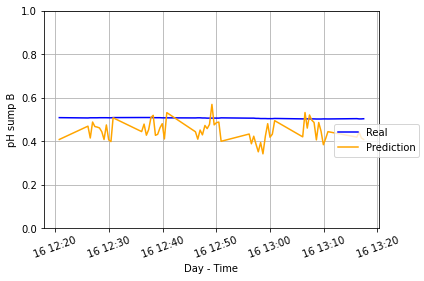

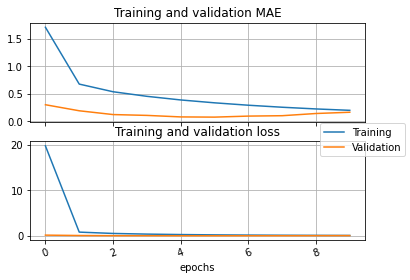

In [35]:
max_epochs = 10
batch_size = 50

linear_history, linear_prediction = compile_and_fit(linear_model, train_data, train_target, val_data, val_target, 
                                                    test_data, test_target, max_epochs, batch_size, test_entry, label_width)

## MLP model

In [21]:
def f_mlp_model(label_target, label_width):
    model = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            
            tf.keras.layers.Dense(units = 5000, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
        
            tf.keras.layers.Dense(units = 1000, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
        
            tf.keras.layers.Dense(units = 500, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
        
            tf.keras.layers.Dense(units = 200, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),

        
            tf.keras.layers.Dense(units = len(label_target) * label_width)])
    return model
    
mlp_model = f_mlp_model(label_target, label_width)

Train on 19849 samples, validate on 5531 samples
Epoch 1/20
19849/19849 [==============================] - 9s 438us/sample - loss: 0.2435 - mean_absolute_error: 0.2454 - val_loss: 0.0053 - val_mean_absolute_error: 0.0591
Epoch 2/20
19849/19849 [==============================] - 7s 360us/sample - loss: 0.0138 - mean_absolute_error: 0.0905 - val_loss: 0.0019 - val_mean_absolute_error: 0.0364
Epoch 3/20
19849/19849 [==============================] - 7s 359us/sample - loss: 0.0100 - mean_absolute_error: 0.0754 - val_loss: 0.0014 - val_mean_absolute_error: 0.0304
Epoch 4/20
19849/19849 [==============================] - 7s 353us/sample - loss: 0.0070 - mean_absolute_error: 0.0619 - val_loss: 0.0015 - val_mean_absolute_error: 0.0310
Epoch 5/20
19849/19849 [==============================] - 7s 357us/sample - loss: 0.0050 - mean_absolute_error: 0.0505 - val_loss: 0.0017 - val_mean_absolute_error: 0.0335
Epoch 6/20
19849/19849 [==============================] - 7s 354us/sample - loss: 0.0037 - 

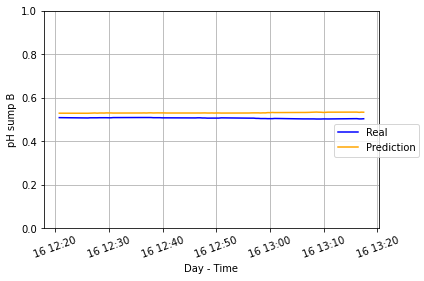

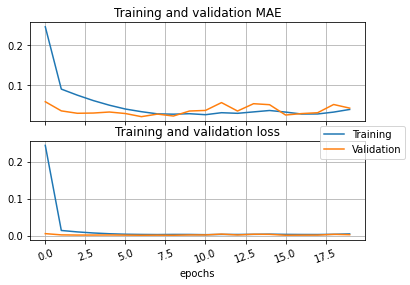

In [22]:
max_epochs = 20
batch_size = 50
mlp_history, mlp_prediction = compile_and_fit(mlp_model, train_data, train_target, val_data, val_target, 
                                              test_data, test_target, max_epochs, batch_size, test_entry, label_width)

## LSTM RNN model

In [23]:
def f_lstm_model(input_shape, output_shape):
    model = tf.keras.Sequential([

            tf.keras.layers.LSTM(units = 600, input_shape = input_shape, kernel_initializer='random_normal', bias_initializer='zeros', dropout=0.2, return_sequences=True),
        
#             tf.keras.layers.LSTM(units = 200, input_shape = input_shape, kernel_initializer='random_normal', bias_initializer='zeros', dropout=0.2, return_sequences=True), 
        
            tf.keras.layers.LSTM(units = 300, input_shape = input_shape, kernel_initializer='random_normal', bias_initializer='zeros', dropout=0.2, return_sequences=False),
        
            tf.keras.layers.Dense(output_shape)])
    return model

input_shape = train_data[0].shape
output_shape = train_target.shape[1]
lstm_model = f_lstm_model(input_shape, output_shape)

Train on 19849 samples, validate on 5531 samples
Epoch 1/20
19849/19849 [==============================] - 25s 1ms/sample - loss: 0.0036 - mean_absolute_error: 0.0285 - val_loss: 0.0027 - val_mean_absolute_error: 0.0446
Epoch 2/20
19849/19849 [==============================] - 20s 1ms/sample - loss: 0.0021 - mean_absolute_error: 0.0204 - val_loss: 0.0017 - val_mean_absolute_error: 0.0349
Epoch 3/20
19849/19849 [==============================] - 20s 1ms/sample - loss: 9.5289e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0030 - val_mean_absolute_error: 0.0451
Epoch 4/20
19849/19849 [==============================] - 20s 1ms/sample - loss: 0.0012 - mean_absolute_error: 0.0184 - val_loss: 0.0021 - val_mean_absolute_error: 0.0393
Epoch 5/20
19849/19849 [==============================] - 20s 1ms/sample - loss: 0.0010 - mean_absolute_error: 0.0161 - val_loss: 0.0017 - val_mean_absolute_error: 0.0353
Epoch 6/20
19849/19849 [==============================] - 20s 1ms/sample - loss: 0.0012 - me

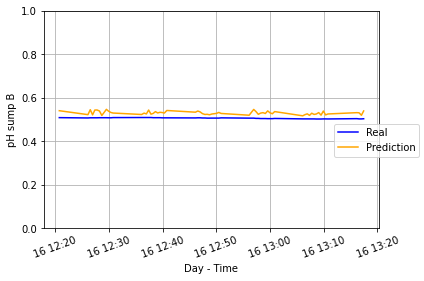

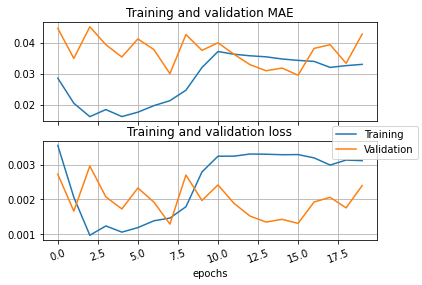

In [24]:
max_epochs = 20
batch_size = 50
lstm_history, lstm_prediction = compile_and_fit(lstm_model, train_data, train_target, val_data, val_target, 
                                                test_data, test_target, max_epochs, batch_size, test_entry, label_width)

## GRU RNN model 

In [25]:
def f_gru_model(input_shape, output_shape):
    model = tf.keras.Sequential([
        
            tf.keras.layers.GRU(units = 500, input_shape = input_shape, kernel_initializer='random_normal', bias_initializer='zeros', dropout=0.2, return_sequences=True),
        
            tf.keras.layers.GRU(units = 200, input_shape = input_shape, kernel_initializer='random_normal', bias_initializer='zeros', dropout=0.2, return_sequences=False),

            tf.keras.layers.Dense(output_shape)])
    return model

input_shape = train_data[0].shape
output_shape = train_target.shape[1]
gru_model = f_gru_model(input_shape, output_shape)

Train on 19849 samples, validate on 5531 samples
Epoch 1/10
19849/19849 [==============================] - 18s 892us/sample - loss: 0.0065 - mean_absolute_error: 0.0485 - val_loss: 0.0092 - val_mean_absolute_error: 0.0763
Epoch 2/10
19849/19849 [==============================] - 13s 678us/sample - loss: 0.0016 - mean_absolute_error: 0.0227 - val_loss: 0.0081 - val_mean_absolute_error: 0.0731
Epoch 3/10
19849/19849 [==============================] - 13s 679us/sample - loss: 0.0013 - mean_absolute_error: 0.0199 - val_loss: 0.0073 - val_mean_absolute_error: 0.0657
Epoch 4/10
19849/19849 [==============================] - 14s 693us/sample - loss: 0.0014 - mean_absolute_error: 0.0198 - val_loss: 0.0102 - val_mean_absolute_error: 0.0791
Epoch 5/10
19849/19849 [==============================] - 14s 683us/sample - loss: 0.0013 - mean_absolute_error: 0.0192 - val_loss: 0.0071 - val_mean_absolute_error: 0.0670
Epoch 6/10
19849/19849 [==============================] - 14s 681us/sample - loss: 0.0

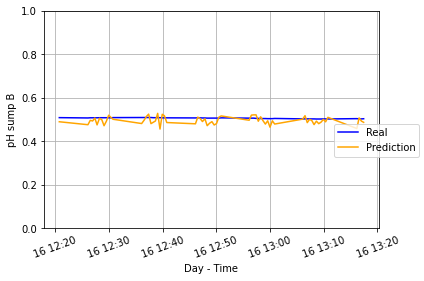

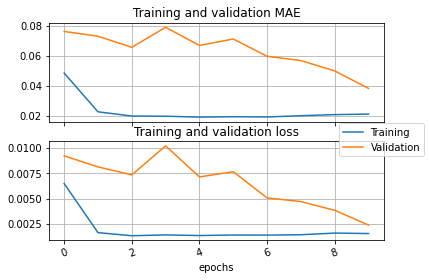

In [26]:
max_epochs = 10
batch_size = 50
gru_history, gru_prediction = compile_and_fit(gru_model, train_data, train_target, val_data, val_target, 
                                              test_data, test_target, max_epochs, batch_size, test_entry, label_width)